# ARIMA

## 模型

解决周期性+有趋势问题的预测

`ARIMA(p, d, q)` = `AR(p)` + `I(d)` + `MA(q)`

- `AR(p)`: 自回归

- `I(d)`: 差分

- `MA(q)`: 移动平均

## 实现

In [270]:
import numpy as np

#! 修改统计学参数
# 置信水平
ALPHA = 0.05

#! 修改输入数据
data = np.array([1, 2, 4, 3, 1, 3, 4, 4, 1, 2, 5, 4, 1, 2, 4, 3, 1, 3, 4, 4, 1, 2, 5, 4, 1, 2, 4, 3, 1, 3, 4, 4, 1, 2, 5, 4, 1, 2, 4, 3, 1, 3, 4, 4, 1, 2, 5, 4, ])


### 选参

#### 确定差分阶数 d

使用 **ADF (Augmented Dickey-Fuller) 检验**

零假设 $H_{0}$：时间序列是非平稳的（存在单位根）


In [271]:
from statsmodels.tsa.stattools import adfuller

adf_result = adfuller(data)

print(f'ADF Statistic: {adf_result[0]:.2f}')
print(f'p-value: {adf_result[1]:.2f}')

if adf_result[1] > 0.05:
    print("p-value > 0.05，序列非平稳，需要进行差分。")
    # 进行一次差分
    data_diff = np.diff(data, n=1)
    print("\n进行一次差分后，再次进行 ADF 检验:")
    adf_result_diff = adfuller(data_diff)
    print(f'ADF 统计量: {adf_result_diff[0]:.2f}')
    print(f'p-value: {adf_result_diff[1]:.2f}')
    if adf_result_diff[1] < 0.05:
        print("p-value < 0.05，序列已平稳，d=1。")
        d = 1
    else:
        print("p-value > 0.05，序列仍非平稳，可能需要二次差分。")
else:
    print("p-value <= 0.05，序列已平稳，d=0。")
    d = 0

ADF Statistic: -104323641013537.81
p-value: 0.00
p-value <= 0.05，序列已平稳，d=0。


#### 确定自回归阶数 p 和移动平均阶数 q

观察平稳序列的 ACF 图和 PACF 图

- PACF 图 $\Rightarrow$ 确定 p

    第一次显著降至置信区间的位置为 p 的可能取值

- ACF 图 $\Rightarrow$ 确定 q

    第一次显著降至置信区间的位置为 q 的可能取值

根据 PACF 图选定 p, ACF 图选定 q
原例中由图 p = 4, q = 3


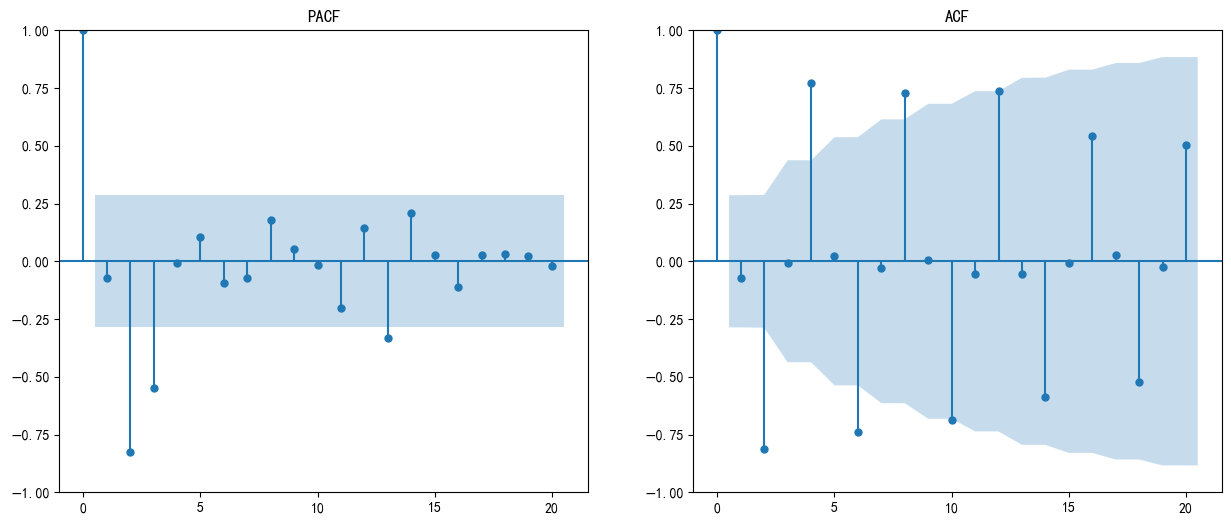

In [272]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.rcParams['font.family'] = 'SimHei,sans-serif' # 中文支持

# 绘制平稳序列（这里假设 d=1）的 ACF 和 PACF 图
data_stationary = np.diff(data, n=1)

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

plot_pacf(data_stationary, ax=axes[0], lags=20, method='ywm')
axes[0].set_title('PACF')

plot_acf(data_stationary, ax=axes[1], lags=20)
axes[1].set_title('ACF')

print("根据 PACF 图选定 p, ACF 图选定 q")
print("原例中由图 p = 4, q = 3")
plt.show()

### 拟合

In [273]:
from statsmodels.tsa.arima.model import ARIMA

#! 修改训练集/测试集比例
TRAIN_TEST_RATIO = 0.8

train_size = int(data.size * TRAIN_TEST_RATIO)
train_set = data[:train_size]
test_set = data[train_size:]

# 训练 ARIMA 模型
# `order` for (p, d, q)
model = ARIMA(train_set, order=(4, 0, 3))
result = model.fit()

print(result.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   38
Model:                 ARIMA(4, 0, 3)   Log Likelihood                 -31.047
Date:                Fri, 15 Aug 2025   AIC                             80.095
Time:                        01:29:45   BIC                             94.833
Sample:                             0   HQIC                            85.338
                                 - 38                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.8346      0.028     99.808      0.000       2.779       2.890
ar.L1         -0.3547      0.562     -0.631      0.528      -1.456       0.746
ar.L2         -0.2839      0.452     -0.628      0.5

c:\Users\DvdBr3o\scoop\persist\anaconda3\App\envs\mcm\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\DvdBr3o\scoop\persist\anaconda3\App\envs\mcm\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\DvdBr3o\scoop\persist\anaconda3\App\envs\mcm\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


### 检验

#### 残差检验

直接看 [拟合](#拟合) 中的两个参数值即可

- `Prob(Q)`: Ljung-Box 检验，零假设 $H_{0}$: 残差序列为白噪声

    - `Prob(Q)` $> \alpha = 0.05$ $\Rightarrow$ 不能拒绝零假设，残差序列为白噪声，模型成立

    - `Prob(Q)` $< \alpha = 0.05$ $\Rightarrow$ 拒绝零假设，残差序列不为白噪声，模型不成立

- `Prob(JB)`: Jarque-Bera 检验，零假设 $H_{0}$: 残差符合正态分布

    - `Prob(Q)` $> \alpha = 0.05$ $\Rightarrow$ 不能拒绝零假设，残差符合正态分布，模型成立

    - `Prob(Q)` $< \alpha = 0.05$ $\Rightarrow$ 拒绝零假设，残差不符合正态分布，模型不成立

同时可以贴出残差图像，增强说服力

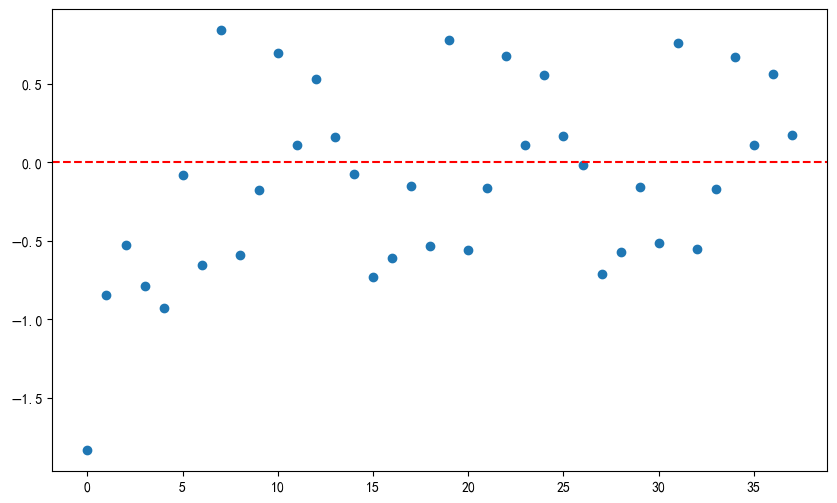

In [274]:
import matplotlib.pyplot as plt

plt.rcParams['font.family'] = 'SimHei,sans-serif' # 中文支持

figres, axres = plt.subplots(figsize=(10, 6))
axres.scatter(range(result.resid.size), result.resid)
axres.axhline(0, color='red', linestyle='--', label='零线') # 添加零线，方便观察

plt.show()

#### 图像检验

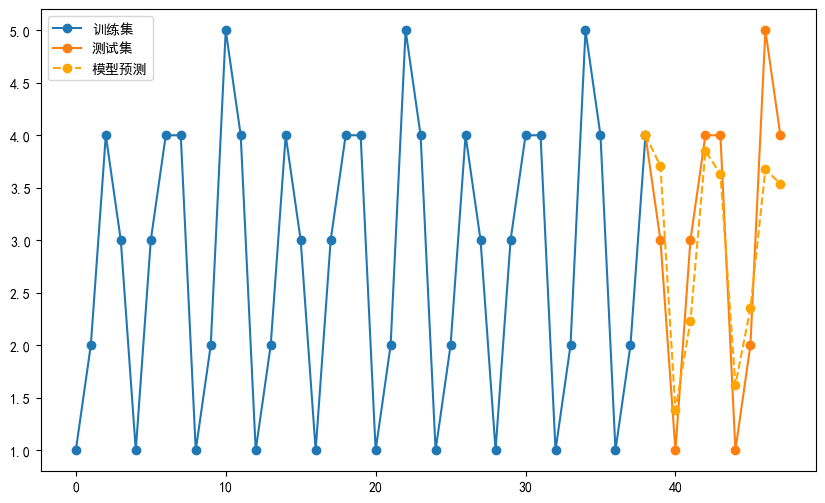

In [275]:
import matplotlib.pyplot as plt

plt.rcParams['font.family'] = 'SimHei' # 中文支持

forecast_test = result.get_forecast(test_set.size)

fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(range(train_set.size + 1), np.concat([train_set, test_set[0:1]]), label='训练集', marker='o')
ax.plot(train_set.size + np.array(range(test_set.size)), test_set, label='测试集', marker='o')
ax.plot(train_set.size + np.array(range(test_set.size)), forecast_test.predicted_mean, label='模型预测', color='orange', linestyle='--', marker='o')
ax.legend()

plt.show()

### 自动选参实现

In [ ]:
import pmdarima as pm

auto_model = pm.auto_arima(data,
                           start_p=1, start_q=1,
                           max_p=3, max_q=3,
                           m=4, # 关键参数：指定季节周期
                           seasonal=True, # 关键参数：启用季节性
                           trace=True,
                           error_action='ignore',
                           suppress_warnings=True,
                           stepwise=True)